In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  
  minlen = min(minlenarr)
  min_disea = type_disea[minlenarr.index(minlen)]
  
#   a = [df.loc[df['labels']==type_disea[0]]]
#   print(df.loc[df['labels']==type_disea[0]] )
#   a = pd.Series(df['labels'])
#   for i in type_disea:
#     a = df.loc[df['labels']==i]
  print('minlenarr ',minlenarr)
  print('type disea ',type_disea) 
  print('min len ',minlen)
  b = pd.DataFrame({})
  for i in type_disea:
    a = df.loc[df['labels'] == i]
    a = a.iloc[:minlen]
    b = pd.concat([b, a], ignore_index=True)
#   print(b)
  return b


minlenarr  [117, 62, 105, 134]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  62
Found 248 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726627693.889029     101 service.cc:145] XLA service 0x79408c0038d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726627693.889118     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726627790.952154     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 286s 19s/step - accuracy: 0.4125 - loss: 1.6300 - val_accuracy: 0.3524 - val_loss: 2.2336
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8038 - loss: 0.4996 - val_accuracy: 0.5905 - val_loss: 1.5093
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9364 - loss: 0.1910 - val_accuracy: 0.7238 - val_loss: 0.6818
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9650 - loss: 0.1478 - val_accuracy: 0.8571 - val_loss: 0.4014
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9602 - loss: 0.0900 - val_accuracy: 0.8667 - val_loss: 0.3369
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9711 - loss: 0.0869 - val_accuracy: 0.8762 - val_loss: 0.3233
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9827 - loss: 0.0474 - val_accuracy: 0.8857 - val_loss: 0.3165
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9965 - loss: 0.0312 - val_accuracy: 0.8857 - val_loss: 0.2639
Epoch 9/15
8/8 ━━

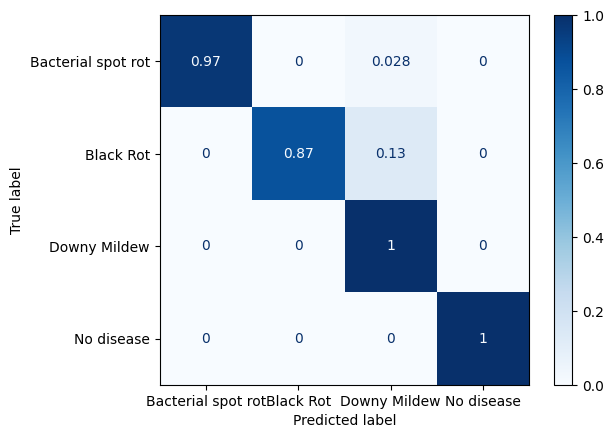

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      0.87      0.93        23
      Downy Mildew       0.89      1.00      0.94        32
        No disease       1.00      1.00      1.00        42

          accuracy                           0.97       133
         macro avg       0.97      0.96      0.96       133
      weighted avg       0.97      0.97      0.97       133

minlenarr  [113, 64, 111, 130]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  64
Found 256 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.4930 - loss: 1.3638 - val_accuracy: 0.3429 - val_loss: 1.9272
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7984 - loss: 0.5706 - val_accuracy: 0.6095 - val_loss: 1.0319
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9061 - loss: 0.2800 - val_accuracy: 0.5905 - val_loss: 0.8662
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.9783 - loss: 0.1026 - val_accuracy: 0.7524 - val_loss: 0.8307
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9642 - loss: 0.0830 - val_accuracy: 0.7810 - val_loss: 0.7599
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9678 - loss: 0.0740 - val_accuracy: 0.8000 - val_loss: 0.7355
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9601 - loss: 0.0760 - val_accuracy: 0.8000 - val_loss: 0.8122
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9972 - loss: 0.0184 - val_accuracy: 0.7333 - val_loss: 1.0195
Epoch 9/15
8/8 ━━━

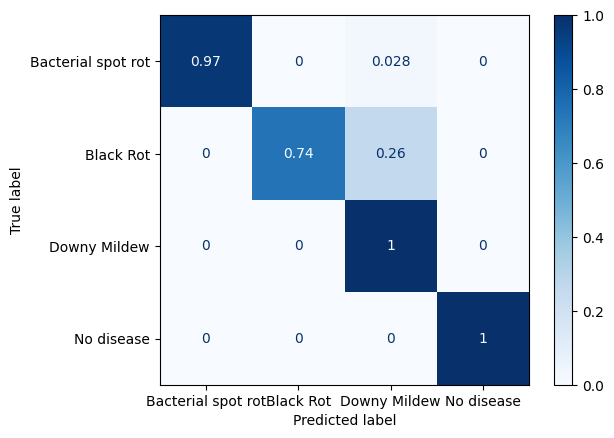

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      0.74      0.85        27
      Downy Mildew       0.78      1.00      0.88        28
        No disease       1.00      1.00      1.00        42

          accuracy                           0.94       133
         macro avg       0.94      0.93      0.93       133
      weighted avg       0.95      0.94      0.94       133

minlenarr  [109, 68, 112, 129]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  68
Found 272 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 263s 15s/step - accuracy: 0.3803 - loss: 1.5288 - val_accuracy: 0.5905 - val_loss: 0.9353
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8634 - loss: 0.3689 - val_accuracy: 0.6571 - val_loss: 0.8542
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9145 - loss: 0.2907 - val_accuracy: 0.8762 - val_loss: 0.4525
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9371 - loss: 0.1976 - val_accuracy: 0.8667 - val_loss: 0.3974
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9838 - loss: 0.0583 - val_accuracy: 0.8857 - val_loss: 0.3707
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9780 - loss: 0.0613 - val_accuracy: 0.8571 - val_loss: 0.3584
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9873 - loss: 0.0339 - val_accuracy: 0.8667 - val_loss: 0.3259
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9718 - loss: 0.0932 - val_accuracy: 0.8952 - val_loss: 0.2680
Epoch 9/15
9/9 ━━

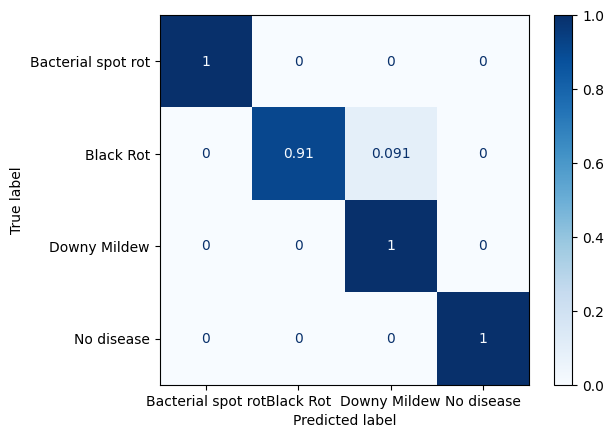

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.91      0.95        22
      Downy Mildew       0.94      1.00      0.97        34
        No disease       1.00      1.00      1.00        42

          accuracy                           0.98       133
         macro avg       0.99      0.98      0.98       133
      weighted avg       0.99      0.98      0.98       133

minlenarr  [109, 68, 110, 132]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  68
Found 272 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 256s 15s/step - accuracy: 0.4341 - loss: 1.5146 - val_accuracy: 0.3750 - val_loss: 2.7905
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8421 - loss: 0.4140 - val_accuracy: 0.5192 - val_loss: 1.9075
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9752 - loss: 0.1048 - val_accuracy: 0.7212 - val_loss: 1.0018
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9989 - loss: 0.0473 - val_accuracy: 0.8077 - val_loss: 0.5915
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9702 - loss: 0.0911 - val_accuracy: 0.8654 - val_loss: 0.3392
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9867 - loss: 0.0637 - val_accuracy: 0.9231 - val_loss: 0.2163
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9881 - loss: 0.0310 - val_accuracy: 0.9615 - val_loss: 0.1490
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9979 - loss: 0.0279 - val_accuracy: 0.9712 - val_loss: 0.1263
Epoch 9/15
9/9 ━━

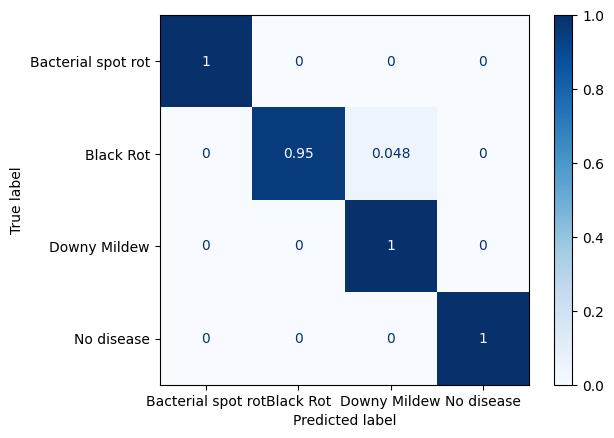

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

minlenarr  [116, 58, 114, 131]
type disea  ['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']
min len  58
Found 232 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/8 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3457 - loss: 1.8020

I0000 00:00:1726630480.817495     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 256s 17s/step - accuracy: 0.3675 - loss: 1.7206 - val_accuracy: 0.3942 - val_loss: 1.6552
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8647 - loss: 0.4419 - val_accuracy: 0.5192 - val_loss: 1.3661
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9094 - loss: 0.2243 - val_accuracy: 0.7019 - val_loss: 0.8778
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9513 - loss: 0.1566 - val_accuracy: 0.7308 - val_loss: 0.7801
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9426 - loss: 0.1486 - val_accuracy: 0.8077 - val_loss: 0.6429
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9881 - loss: 0.0501 - val_accuracy: 0.8462 - val_loss: 0.4864
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9806 - loss: 0.0470 - val_accuracy: 0.8846 - val_loss: 0.3528
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9853 - loss: 0.0452 - val_accuracy: 0.9231 - val_loss: 0.2463
Epoch 9/15
8/8 ━━

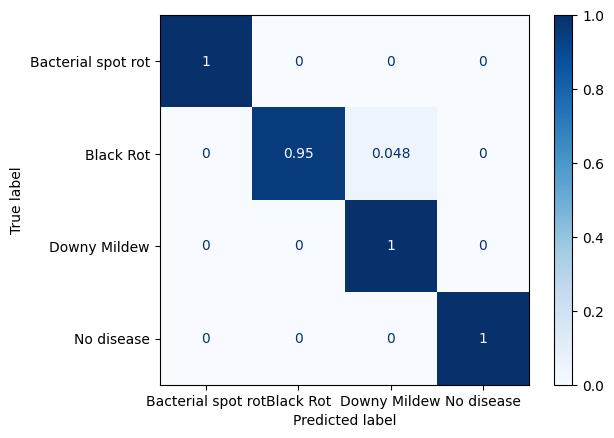

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133



In [8]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])
epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  a = make_balance_train(train_df.loc[train_idx])
  b = train_df.loc[valid_idx]
  train = gen.flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)